In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('./gdrive/My Drive/Colab Notebooks/growth_hackers')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
style.use('fivethirtyeight')

In [0]:
ted=pd.read_csv('ted.csv')

#AutoEncoder
https://yamalab.tistory.com/118

https://datascience.stackexchange.com/questions/25712/how-can-autoencoders-be-used-for-clustering

https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

In [0]:
#먼저 views로 각 반응들 나눠서 비율 칼럼만들기
for i,col in enumerate(ted.columns):
  if i >= 3 and i <=16:
    ted[col] = ted[col]/ted['views']

In [0]:
X=ted.iloc[:,3:17]
X=X.to_numpy()

In [0]:
#train set split
num_of_rows = (2550) * 0.98 # 2499
np.random.shuffle(X) 
X_train = X[:2499] 
X_test = X[2499:] 
X_train.sort() 
X_test.sort()

In [0]:
X_train.shape

(2499, 2, 7, 1)

# DNN AutoEncoder

In [0]:
X_train=X_train.reshape(-1,2,7)
X_test=X_test.reshape(-1,2,7)
X=X.reshape(-1,2,7)

In [0]:
model = Sequential()
input_shape=(2,7)

model.add(Dense(14, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(14, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='relu'))

In [0]:

model.compile(optimizer='adam', loss="mse")


In [0]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 2, 14)             112       
_________________________________________________________________
dense_111 (Dense)            (None, 2, 256)            3840      
_________________________________________________________________
dropout_85 (Dropout)         (None, 2, 256)            0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 2, 256)            1024      
_________________________________________________________________
dense_112 (Dense)            (None, 2, 512)            131584    
_________________________________________________________________
dropout_86 (Dropout)         (None, 2, 512)            0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 2, 512)          

In [0]:
model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_test, X_test), verbose=1)


Train on 2499 samples, validate on 51 samples
Epoch 1/10
2499/2499 [==============================] - 5s 2ms/step - loss: 1.6218e-04 - val_loss: 3.4176e-08
Epoch 2/10
2499/2499 [==============================] - 1s 454us/step - loss: 6.0375e-08 - val_loss: 3.4176e-08
Epoch 3/10
2499/2499 [==============================] - 1s 474us/step - loss: 5.4289e-08 - val_loss: 3.4176e-08
Epoch 4/10
2499/2499 [==============================] - 1s 453us/step - loss: 4.7020e-08 - val_loss: 3.4176e-08
Epoch 5/10
2499/2499 [==============================] - 1s 440us/step - loss: 5.5199e-08 - val_loss: 3.4176e-08
Epoch 6/10
2499/2499 [==============================] - 1s 422us/step - loss: 5.2357e-08 - val_loss: 3.4176e-08
Epoch 7/10
2499/2499 [==============================] - 1s 434us/step - loss: 5.5730e-08 - val_loss: 3.4176e-08
Epoch 8/10
2499/2499 [==============================] - 1s 397us/step - loss: 4.9432e-08 - val_loss: 3.4176e-08
Epoch 9/10
2499/2499 [==============================] - 1s 4

In [0]:
# Extract the encoder
encoder = K.function([model.layers[0].input], [model.layers[4].output])
# Encode the training set
encoded_result= encoder([X])[0].reshape(-1,1)
# Cluster the training set
# Cluster the training set
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
clustered= kmeans.fit_predict(encoded_result)

# kmeans ->ted에 넣기

In [0]:
ted['predict']=pd.DataFrame(clustered)

In [0]:
t=ted.drop(columns=['video_num','comments','duration','views','tags'])

In [0]:
t.head()

,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,predict
0,0.000416,0.000097,0.000129,0.000069,0.000008,0.000005,0.000156,0.000224,0.000006,0.000227,0.000094,0.000025,0.000004,0.000528,0
1,0.000170,0.000043,0.000019,0.000018,0.000081,0.000035,0.000138,0.000129,0.000041,0.000017,0.000084,0.000036,0.000041,0.000063,0
2,0.000589,0.000028,0.000112,0.000037,0.000064,0.000048,0.000241,0.000141,0.000101,0.000017,0.000089,0.000141,0.000033,0.000087,0
3,0.000448,0.000171,0.000019,0.000035,0.000062,0.000021,0.000031,0.000224,0.000630,0.000078,0.000271,0.000135,0.000021,0.000050,0
4,0.000267,0.000116,0.000078,0.000026,0.000009,0.000006,0.000006,0.000453,0.000241,0.000384,0.000311,0.000212,0.000021,0.000005,0


In [0]:
def func(row): #row number 0~10
  global df
  df=t.iloc[row].T.reset_index()
  predict=df.iloc[-1,1]
  df=df.drop(14,0)
  df=df.rename(columns={'index':'reaction',df.columns[1]:'values'})
  df['label']=predict
  
  return df

In [0]:
result=pd.DataFrame()
for i in range(len(t)):
  result=pd.concat([result,func(i)])

In [0]:
result['label'].isnull().sum()

0

In [0]:
result.groupby('label').count()

,reaction,values
label,,
0.0,28644,28644
1.0,1190,1190
2.0,1820,1820
3.0,490,490
4.0,1456,1456
5.0,2100,2100


In [0]:
'''
import tensorflow as tf
from sklearn.manifold import TSNE

np.random.seed(123)

km = KMeans(n_clusters=10).fit(encoded_result)
tsne=TSNE().fit_transform(encoded_result)
plt.scatter(x=tsne[:,0],y=tsne[:,1], c=km.labels_)
'''

(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04]),
 <a list of 10 Text yticklabel objects>)

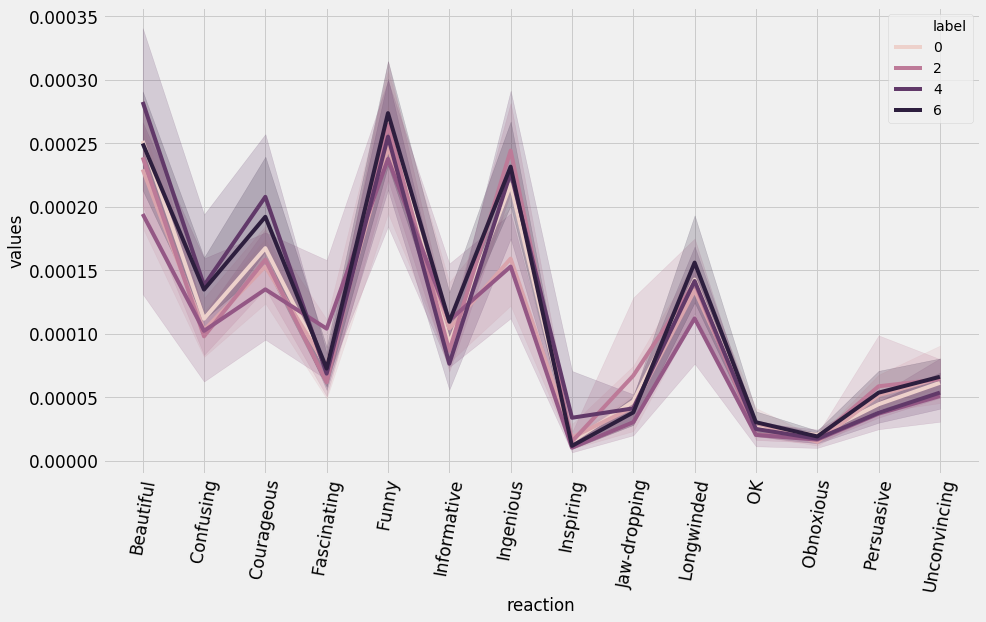

In [0]:
f,ax = plt.subplots(figsize=(14,8))
sns.lineplot(x='reaction', y='values',hue='label', data=result,ax=ax)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
#ax.set_ylim(min(result['values']),max(result['values']))

In [0]:
result['label']=pd.to_numeric(result['label'],downcast='integer')

In [0]:
target=ted.loc[(ted['video_num']==27)|(ted['video_num']==1110)|(ted['video_num']==1995)]
target
#분류된 걸 보니까 별볼일 없는 애들 반응 잘 안하는 애들임


,video_num,duration,comments,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,tags,views,predict
26,27,1316,507,0.000115,0.000039,0.000044,0.000144,0.000015,0.000032,0.000226,0.000234,0.000444,0.000112,0.000014,0.000127,0.000032,0.000014,"['astronomy', 'biology', 'cognitive science', ...",2885999,0
1109,1110,548,161,0.000333,0.000464,0.000609,0.000026,0.000004,0.000252,0.000161,0.000155,0.000027,0.000006,0.000006,0.000010,0.000006,0.000002,"['DNA', 'TEDx', 'biology', 'biotech', 'compute...",1443353,0
1994,1995,1310,378,0.000038,0.000130,0.000385,0.000206,0.000076,0.000031,0.000030,0.000033,0.000045,0.000021,0.000026,0.000070,0.000080,0.000007,"['animals', 'biology', 'brain', 'cognitive sci...",2471075,4


In [0]:
tl=result.loc[(result['label']==0)|(result['label']==4)]

In [0]:
tl.head()

,reaction,values,label
0,Funny,0.000416,0
1,Beautiful,0.000097,0
2,Ingenious,0.000129,0
3,Courageous,0.000069,0
4,Longwinded,0.000008,0


(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04]),
 <a list of 10 Text yticklabel objects>)

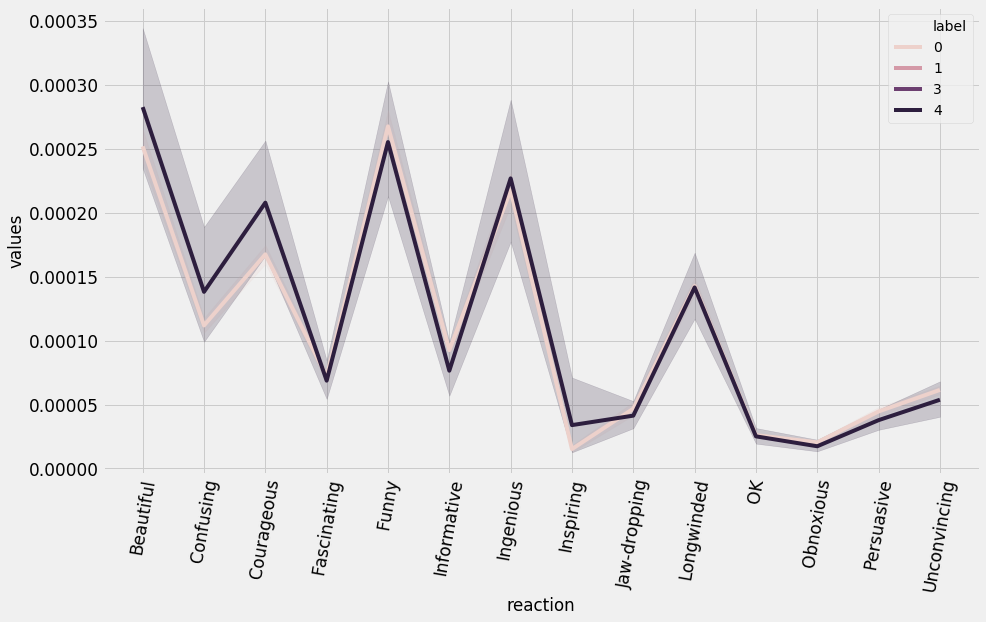

In [0]:
f,ax = plt.subplots(figsize=(14,8))
sns.lineplot(x='reaction', y='values',hue='label', data=tl,ax=ax)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)